<h1 style="text-align: center;">
    🌐 Generating Analog Wafer Maps
</h1>

This notebook demonstrates a more complicated use-case.

We will create an analog wafer map stream based on the [wm811k dataset](https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map) [^1].

A pre-processed version of the dataset split into the labeled patterns is included in `examples/data`.

<link rel="stylesheet" href="https://cdn.jupyter.org/notebook/7.1.0/style/style.min.css">


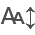

In [1]:
from collections.abc import Callable
from math import ceil
from pathlib import Path

import itables
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import torch
from IPython.display import HTML
from IPython.utils import io
from matplotlib.animation import FuncAnimation
from matplotlib.figure import Figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from perlin_numpy import generate_perlin_noise_2d
from rich import print
from torchvision.transforms.functional import InterpolationMode, resize

from streamgen.parameter.store import ParameterStore
from streamgen.samplers.tree import SamplingTree

SEED=42
rng = np.random.default_rng(SEED)

matplotlib.style.use("ggplot")
plt.ioff()  # disable interactive mode of matplotlib in order to show the plot just once

pd.options.display.max_seq_items = 2 #needed to compactly display large nested lists
itables.init_notebook_mode(all_interactive=False)
itables.options.maxBytes = 0 # determines if the output should be reduced. 0 means no reduction -> full dataframe
itables.options.scrollx = True
itables.options.scrolly = True
itables.options.classes = "display compact"
itables.options.style = "table-layout:auto;width:100%;margin:auto;caption-side:bottom"


def preprocess(x):
    x = np.array(x.to_list(), dtype=np.float32)

    # switch values for a better zero-center distribution
    x[x==0] = np.nan
    x[x==1] = 0
    x[x==2] = 1

    return x

def plot(wafermap: np.ndarray, title: str | None = None, create_fig: bool = True, **kwargs) -> Figure | None:  # noqa: FBT001, FBT002
    if create_fig:
        fig = plt.figure()

    ax = sns.heatmap(wafermap.T, cmap="jet", cbar=True, **kwargs)
    ax.grid(True)
    ax.invert_yaxis()
    if title:
        ax.set_title(title)

    return fig if create_fig else None

In [2]:
data_dir = Path("data")

patterns = [f.stem for f in data_dir.iterdir()]
print(patterns)

['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'none', 'Random', 'Scratch']

In [3]:
df = pl.read_parquet("data/Center.parquet")
itables.show(df.sample(8).to_pandas())

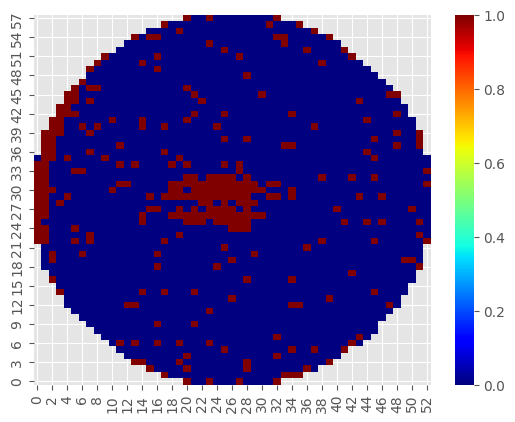

In [4]:
plot(preprocess(df["WaferMap"][0]));

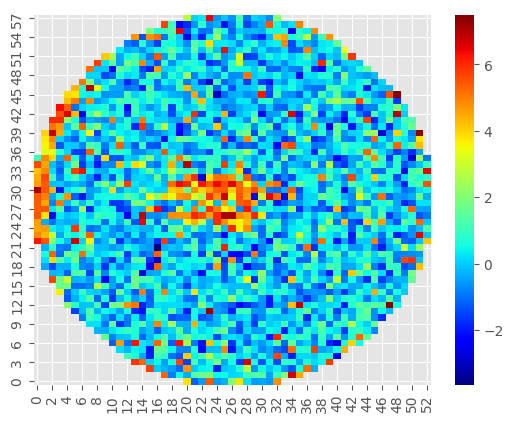

In [5]:
# 🔔 gaussian background noise
pattern_signal = preprocess(df["WaferMap"][0])
mask = np.isnan(pattern_signal)
background = rng.normal(size=pattern_signal.shape)
background[mask] = np.nan
plot(background + pattern_signal*5);

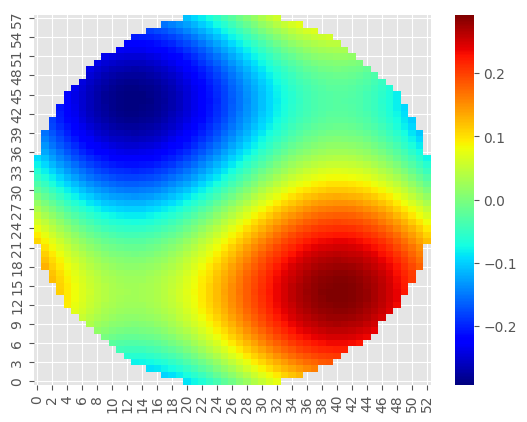

In [6]:
# perlin noise
background = generate_perlin_noise_2d(pattern_signal.shape, (1,1), (True, True)) #https://github.com/pvigier/perlin-numpy
background[mask] = np.nan
plot(background);

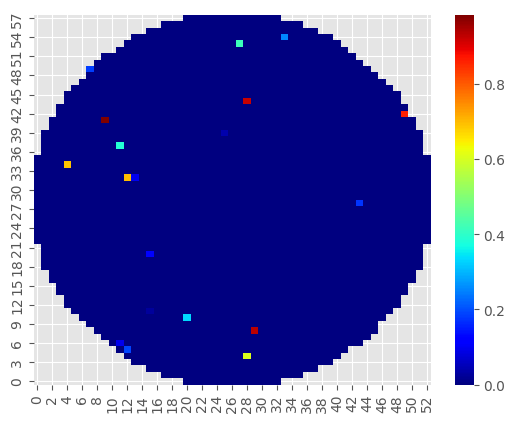

In [7]:
# 🔨 impulse noise
noise_fraction = 0.01

x, y = mask.shape

background = np.zeros(shape=mask.shape)
for _ in range(ceil(noise_fraction*x*y)):
    x_ = rng.integers(x)
    y_ = rng.integers(y)
    background[x_,y_] = rng.uniform()

background[mask] = np.nan

plot(background);

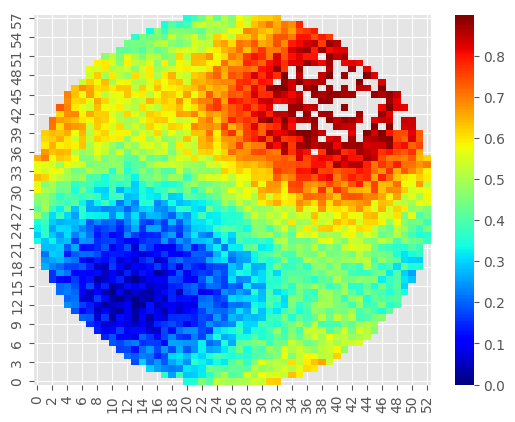

In [8]:
# 🤷 nan noise (aka. missing measurements)

threshold = 0.9

# generate noise
background = generate_perlin_noise_2d(pattern_signal.shape, (1,1), (True, True)) #https://github.com/pvigier/perlin-numpy
background += rng.uniform(high=0.1, size=pattern_signal.shape)
# normalize
background = (background - background.min()) / (background.max() - background.min())
background[mask] = np.nan
background[background>threshold] = np.nan
plot(background);

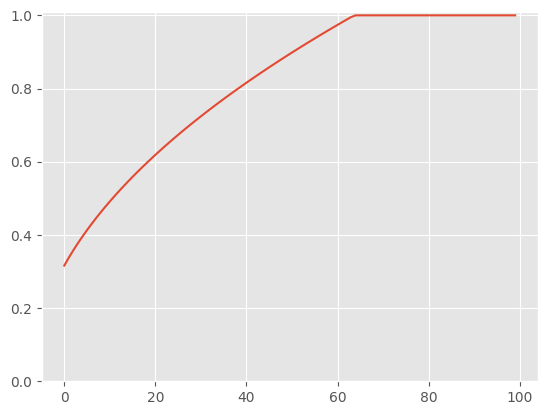

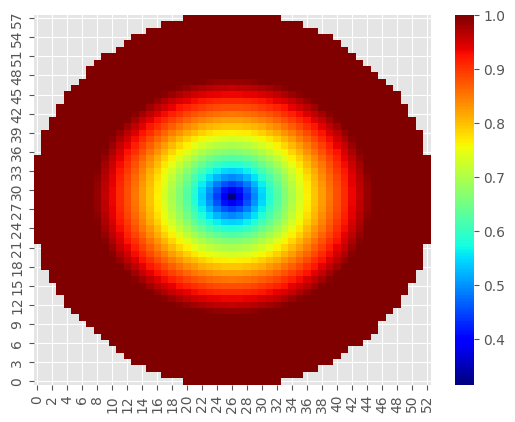

In [9]:
# 🛞 radial gradient

def damping(dist: float):
    # return 0.2 * dist + 0.5
    return np.clip(np.sqrt(1.4 * dist + 0.1), 0, 1)

sns.lineplot(damping(np.linspace(0.0,1.0, 100))).set_ylim((0.0, 1.01))

background = np.ones(pattern_signal.shape)
center_x = pattern_signal.shape[0] // 2
center_y = pattern_signal.shape[1] // 2

for x in range(pattern_signal.shape[0]):
    for y in range(pattern_signal.shape[1]):
        norm_distance = np.sqrt((x-center_x)**2 + (y - center_y)**2) / max(center_x, center_y)
        background[x,y] = damping(norm_distance)

background[mask] = np.nan
plot(background);

In [10]:
# ➡️ functions

def zeros(_: None, shape: tuple[int]) -> np.ndarray:
    """⭕ creates an array with `np.zeros`.

    Args:
        _ (None): input
        shape (tuple[int]): shape of the result

    Returns:
        np.ndarray: an array with all zeros
    """
    return np.zeros(shape)

def add_normal_noise(x: np.ndarray, mean: float = 0.0, std: float = 1.0) -> np.ndarray:
    """🔔 adds normal/gaussian noise to the input.

    Args:
        x (np.ndarray): input array
        mean (float, optional): center of normal distribution. Defaults to 0.0.
        std (float, optional): standard deviation of normal distribution. Defaults to 1.0.

    Returns:
        np.ndarray: input + noise
    """
    return x + rng.normal(loc=mean, scale=std, size=x.shape)

def add_uniform_noise(x: np.ndarray, low: float = 0.0, high: float = 1.0) -> np.ndarray:
    """👚 adds uniform noise to the input.

    Args:
        x (np.ndarray): input array
        low (float, optional): Lower boundary of the output interval. Defaults to 0.0.
        high (float, optional): upper boundary of the output interval. Defaults to 1.0.

    Returns:
        np.ndarray: input + noise
    """
    return x + rng.uniform(low, high, size=x.shape)

def add_perlin_noise(x: np.ndarray, res: tuple[int, int] = (1,1), low: float = 0.0, high: float = 1.0) -> np.ndarray:
    """⛰️ adds perlin noise to the input.

    uses https://github.com/pvigier/perlin-numpy

    Args:
        x (np.ndarray): input array
        res (tuple[int, int], optional): number of periods of noise to generate along each axis (tuple of two ints).
            Note shape must be a multiple of res. Defaults to (1,1).
        low (float, optional): Lower boundary of the output interval. Defaults to 0.0.
        high (float, optional): upper boundary of the output interval. Defaults to 1.0.

    Returns:
        np.ndarray: input + noise
    """
    noise = generate_perlin_noise_2d(x.shape, res, (True, True))
    # normalize
    noise = (noise - noise.min()) / (noise.max() - noise.min())
    noise = noise * (high - low) + low
    return x + noise

def add_impulse_noise(input: np.ndarray, fraction: float = 0.01, low: float = 0.0, high: float = 1.0) -> np.ndarray:  # noqa: A002
    """🔨 adds `fraction` of uniform(low, high) noise to the input.

    Args:
        input (np.ndarray): input array
        fraction (float, optional): how many elements in x are modified
        low (float, optional): Lower boundary of the output interval. Defaults to 0.0.
        high (float, optional): upper boundary of the output interval. Defaults to 1.0.

    Returns:
        np.ndarray: input + noise
    """
    x, y = input.shape

    noise = np.zeros(shape=input.shape)
    for _ in range(ceil(fraction*x*y)):
        x_ = rng.integers(x)
        y_ = rng.integers(y)
        noise[x_,y_] = rng.uniform(low, high)
    return input + noise

def add_nan_noise(x: np.ndarray, noise_func: Callable[[np.ndarray], np.ndarray] = lambda x: add_uniform_noise(add_perlin_noise(x), high=0.2), threshold: float = 0.95) -> np.ndarray:
    """🤷 samples from `noise_func`, normalizes the result and uses the mask from noise>`threshold` to set elements in `x` to `np.nan`.

    Args:
        x (np.ndarray): input array
        noise_func (Callable, optional): function to sample the noise signal from. Defaults to lambdax:add_uniform_noise(add_perlin_noise(x), high=0.2).
        threshold (float, optional): threshold for setting the values in `x` to `np.nan`. Defaults to 0.95.

    Returns:
        np.ndarray: modified input
    """
    noise = noise_func(np.zeros(x.shape))
    # normalize
    noise = (noise - noise.min()) / (noise.max() - noise.min())

    x[noise>threshold] = np.nan
    return x

def radial_gradient(pattern_signal: np.ndarray) -> np.ndarray:
    """🛞 applies a radial gradient to the input.

    Args:
        pattern_signal (np.ndarray): input array

    Returns:
        np.ndarray: modified input
    """
    def damping(dist: float) -> float:
        return np.clip(np.sqrt(1.4 * dist + 0.1), 0, 1)

    gradient = np.ones(pattern_signal.shape)
    center_x = pattern_signal.shape[0] // 2
    center_y = pattern_signal.shape[1] // 2

    for x in range(pattern_signal.shape[0]):
        for y in range(pattern_signal.shape[1]):
            norm_distance = np.sqrt((x-center_x)**2 + (y - center_y)**2) / max(center_x, center_y)
            gradient[x,y] = damping(norm_distance)

    return pattern_signal * gradient

🌳
➡️ `zeros(shape=(60, 60))`
╰── ➡️ `add_normal_noise(mean=0.0, std=0.1)`
    ╰── ➡️ `add_uniform_noise(high=0.2, low=0.0)`
        ╰── ➡️ `add_impulse_noise(fraction=0.01, high=0.05, low=-0.05)`
            ╰── ➡️ `add_perlin_noise(high=0.5, low=0.0, res=(2, 2))`
                ╰── ➡️ `add_nan_noise(threshold=0.9)`
                    ╰── ➡️ `radial_gradient()`

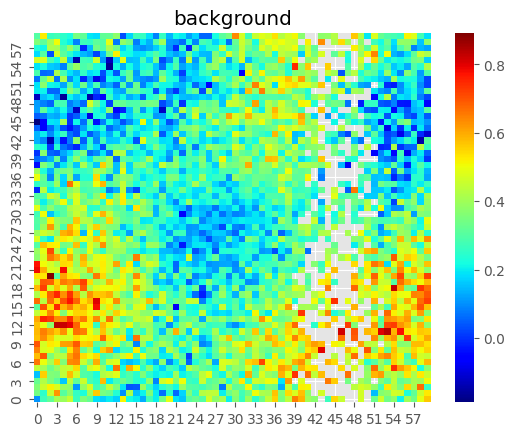

In [11]:
%matplotlib inline

params = ParameterStore(
    {
        "zeros": {"shape": {"value": (60, 60) }},
        "add_normal_noise": {
            "mean": {"value": 0.0 },
            "std": {"value": 0.1 },
        },
        "add_uniform_noise": {
            "low": {"value": 0.0 },
            "high": {"value": 0.2 },
        },
        "add_impulse_noise": {
            "fraction": {"value": 0.01 },
            "low": {"value": -0.05 },
            "high": {"value": 0.05 },
        },
        "add_perlin_noise": {
            "res": {"value": (2,2) },
            "low": {"value": 0.0 },
            "high": {"value": 0.5 },
        },
        "add_nan_noise": {
            "threshold": {"value": 0.90 },
        },
    },
)

background = SamplingTree(
    [
        zeros,
        add_normal_noise,
        add_uniform_noise,
        add_impulse_noise,
        add_perlin_noise,
        add_nan_noise,
        radial_gradient,
    ],
    params,
)

print(background)

sample = background.sample()
plot(sample, title="background");

In [12]:
class PatternSampler:
    """🎲 samples wafermaps from a dataframe.

    Args:
        parquet_path (Path): path to parquet file
    """
    def __init__(self, parquet_path: Path) -> None:  # noqa: D107
        self.df = pl.read_parquet(parquet_path)
        self.__name__ = "PatternSampler"

    def __call__(self, input: np.ndarray, high: float = 1.0) -> np.ndarray:
        """Samples a wafer map from `self.df["WaferMap"]`, preprocesses it and adds the result to the input.

        Args:
            input (np.ndarray): input array
            high (float, optional): value to use for the pattern. Defaults to 1.0.

        Returns:
            np.ndarray: input + sampled and preprocessed pattern
        """
        x = np.array(self.df["WaferMap"].sample().to_list(), dtype=np.float32)

        # switch values for a better zero-center distribution
        x[x==0] = np.nan
        x[x==1] = 0
        x[x==2] = high

        x = resize(torch.tensor(x).unsqueeze(0), input.shape, interpolation=InterpolationMode.NEAREST).squeeze().numpy()

        # option 1: set values
        #input = np.where(x>0, x, input)
        # option 2: add values
        input += x

        mask = np.isnan(x)
        input[mask] = np.nan

        return input

# add params for pattern sampler
params |= ParameterStore({"PatternSampler": {"high": {"value": 1.0}}})

pattern_branches = {
    pattern: [PatternSampler(Path(f"data/{pattern}.parquet")), pattern] for pattern in patterns
}

tree = SamplingTree(
    [
        zeros,
        add_normal_noise,
        add_uniform_noise,
        add_impulse_noise,
        add_perlin_noise,
        add_nan_noise,
        radial_gradient,
        pattern_branches,
    ],
    params,
)

print(tree)

num_samples = 16
samples = tree.collect(num_samples)

🌳
➡️ `zeros(shape=(60, 60))`
╰── ➡️ `add_normal_noise(mean=0.0, std=0.1)`
    ╰── ➡️ `add_uniform_noise(high=0.2, low=0.0)`
        ╰── ➡️ `add_impulse_noise(fraction=0.01, high=0.05, low=-0.05)`
            ╰── ➡️ `add_perlin_noise(high=0.5, low=0.0, res=(2, 2))`
                ╰── ➡️ `add_nan_noise(threshold=0.9)`
                    ╰── ➡️ `radial_gradient()`
                        ╰── 🪴 `branching point()`
                            ├── ➡️ `PatternSampler(high=1.0)`
                            │   ╰── 🏷️ `Center`
                            ├── ➡️ `PatternSampler(high=1.0)`
                            │   ╰── 🏷️ `Donut`
                            ├── ➡️ `PatternSampler(high=1.0)`
                            │   ╰── 🏷️ `Edge-Loc`
                            ├── ➡️ `PatternSampler(high=1.0)`
                            │   ╰── 🏷️ `Edge-Ring`
                            ├── ➡️ `PatternSampler(high=1.0)`
                            │   ╰── 🏷️ `Loc`
                            ├── ➡️ `PatternSampler(high=1.0)`
                            │   ╰── 🏷️ `Near-full`
                            ├── ➡️ `PatternSampler(high=1.0)`
                            │   ╰── 🏷️ `none`
                            ├── ➡️ `PatternSampler(high=1.0)`
                            │   ╰── 🏷️ `Random`
                            ╰── ➡️ `PatternSampler(high=1.0)`
                                ╰── 🏷️ `Scratch`

Output()

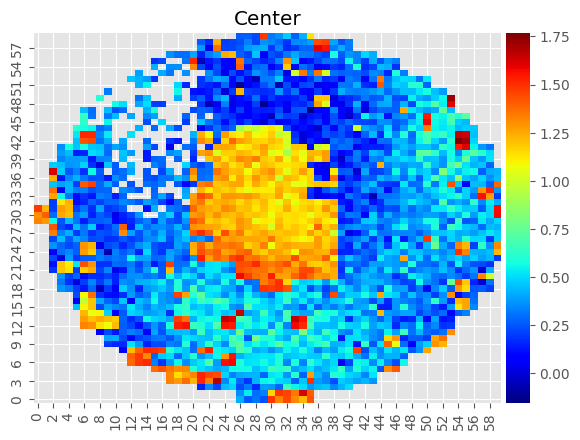

In [13]:
with io.capture_output() as captured:
    def create_frame(idx, ax, cax) -> None:  # noqa: D103, ANN001
        ax.cla()
        cax.cla()
        signal, target = samples[idx]
        sns.heatmap(signal.T, cmap="jet", cbar=True, cbar_ax=cax, ax=ax);
        ax.grid(True)
        ax.set_title(target)
        ax.invert_yaxis()

    fig = plt.figure()
    ax = fig.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    animation = FuncAnimation(fig, create_frame, frames=num_samples, fargs=(ax, cax))
HTML(animation.to_jshtml())

## 📄 References

[^1]: Wu, Ming-Ju, Jyh-Shing R. Jang, and Jui-Long Chen. “Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets.” IEEE Transactions on Semiconductor Manufacturing 28, no. 1 (February 2015): 1–12.